In [95]:

import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adam
from glob import glob
import cv2
import random

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


## Config

In [96]:
imgs_dir="/media/luma/hd1t/Documentos/Mestrado/experimentos/dados/dermnet_teste/imgs"
out_dir="/media/luma/hd1t/Documentos/Mestrado/experimentos/dados/dermnet_teste/results/experiment1"

N_CLASSES=3
EPOCHS=2
LEARNING_RATE=0.001

BATCH_SIZE = 16
IMG_WIDTH, IMG_HEIGHT = 224, 224
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)


In [97]:
filenames_dir= os.path.join(out_dir, 'filenames')
model_dir= os.path.join(out_dir, 'model')
results_dir= os.path.join(out_dir, 'result')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(filenames_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Carrega Dados

In [98]:
train_images = sorted(glob(os.path.join(imgs_dir, "*/*.jpg")))
print(len(train_images))
train_images[-5]

3052


'/media/luma/hd1t/Documentos/Mestrado/experimentos/dados/dermnet_teste/imgs/Psoriasis pictures Lichen Planus and related diseases/seborrheic-dermatitis-94.jpg'

/tmp/ipykernel_12142/3087341346.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


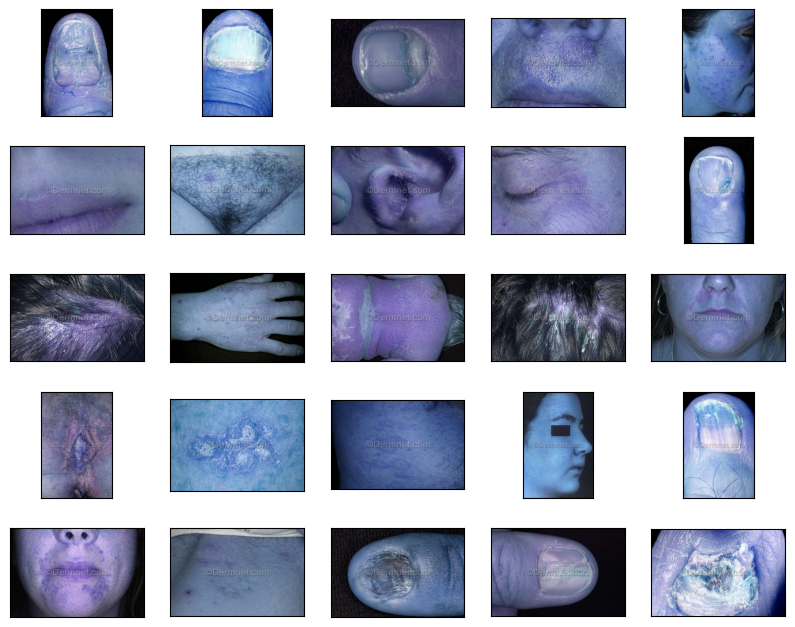

In [99]:
example_list = [image for image in random.sample(train_images, k=25)]
example_list

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    image = cv2.imread(example_list[i])
    plt.imshow(image)
plt.show()

In [100]:
train_data=[]
train_labels=[]
for imagePath in train_images:
    label = os.path.basename(os.path.dirname(imagePath))
    train_labels.append(label)
print(list(set(train_labels)))
print(len(list(set(train_labels))))

['Psoriasis pictures Lichen Planus and related diseases', 'Acne and Rosacea Photos', 'Nail Fungus and other Nail Disease']
3


In [101]:
df_data = pd.DataFrame({'filename': train_images, 'label': train_labels})
df_data.to_csv(os.path.join(filenames_dir,'full_dataset.csv'), index=False)
df_data

,filename,label
0,/media/luma/hd1t/Documentos/Mestrado/experimen...,Acne and Rosacea Photos
1,/media/luma/hd1t/Documentos/Mestrado/experimen...,Acne and Rosacea Photos
2,/media/luma/hd1t/Documentos/Mestrado/experimen...,Acne and Rosacea Photos
3,/media/luma/hd1t/Documentos/Mestrado/experimen...,Acne and Rosacea Photos
4,/media/luma/hd1t/Documentos/Mestrado/experimen...,Acne and Rosacea Photos
...,...,...
3047,/media/luma/hd1t/Documentos/Mestrado/experimen...,Psoriasis pictures Lichen Planus and related d...
3048,/media/luma/hd1t/Documentos/Mestrado/experimen...,Psoriasis pictures Lichen Planus and related d...
3049,/media/luma/hd1t/Documentos/Mestrado/experimen...,Psoriasis pictures Lichen Planus and related d...
3050,/media/luma/hd1t/Documentos/Mestrado/experimen...,Psoriasis pictures Lichen Planus and related d...


In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_data['filename'], df_data['label'], shuffle=True, test_size=0.20, random_state=42)

print("train: ", len(X_train))
print("test: ", len(X_test))

df_train = pd.DataFrame({'filename': X_train, 'label': y_train})
df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)

df_test = pd.DataFrame({'filename': X_test, 'label': y_test})
df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)

train:  2441
test:  611


Carrega dataset com Gerador

In [104]:

# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    validation_split=0.25
    )
 

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col="filename",
    y_col="label",
    subset="training",
    shuffle=True,
    class_mode="sparse",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    )

validation_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col="filename",
    y_col="label",
    subset="validation",
    shuffle=True,
    class_mode="sparse",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="filename",
    y_col="label",
    seed=42,
    shuffle=False,
    class_mode="sparse",
    # class_mode=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    )

dict_generator = {'test': test_generator,'val':validation_generator ,'train':train_generator}

Found 1831 validated image filenames belonging to 3 classes.
Found 610 validated image filenames belonging to 3 classes.
Found 611 validated image filenames belonging to 3 classes.


(16, 224, 224, 3)


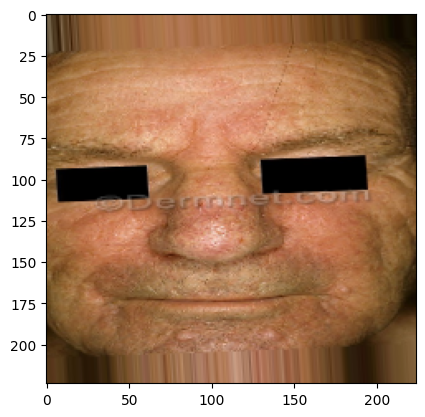

In [61]:
for _ in range(1):
    img, label = validation_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Treinamento

fine-tune the ResNet-50 network to perform image classification.

`include_top=False`: It ensures we can add a custom input and output Keras layer on the pre-trained ResNet-50 network 

`pooling=’avg`: It will use the average pooling technique when building the deep learning model.

`weights=’imagenet`: The ResNet-50 network will use the imagenet weights for classification.

`layer.trainable=False`: It ensures that the ResNet-50 parameters and weights are not trained again to speed up the training process.

In [62]:
model = Sequential()

resnet_model= ResNet50(include_top=False,
                        input_shape=input_shape,
                        pooling='avg',classes=N_CLASSES,
                        weights='imagenet')

# congela as camadas
for layer in resnet_model.layers:
    layer.trainable=False
    
# ultimas camadas densas - as quais serão treinadas
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(N_CLASSES, activation='softmax'))


model.summary()

model.compile(optimizer=Adam(lr=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24638339 (93.99 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [63]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=EPOCHS,
    )

Epoch 1/2
115/115 [==============================] - 400s 3s/step - loss: 1.1352 - accuracy: 0.4085 - val_loss: 1.1365 - val_accuracy: 0.4459
Epoch 2/2
115/115 [==============================] - 353s 3s/step - loss: 1.0551 - accuracy: 0.4653 - val_loss: 1.0182 - val_accuracy: 0.5016


In [64]:
model.save(model_dir)

INFO:tensorflow:Assets written to: /media/luma/hd1t/Documentos/Mestrado/experimentos/dados/dermnet_teste/results/experiment1/model/assets


INFO:tensorflow:Assets written to: /media/luma/hd1t/Documentos/Mestrado/experimentos/dados/dermnet_teste/results/experiment1/model/assets


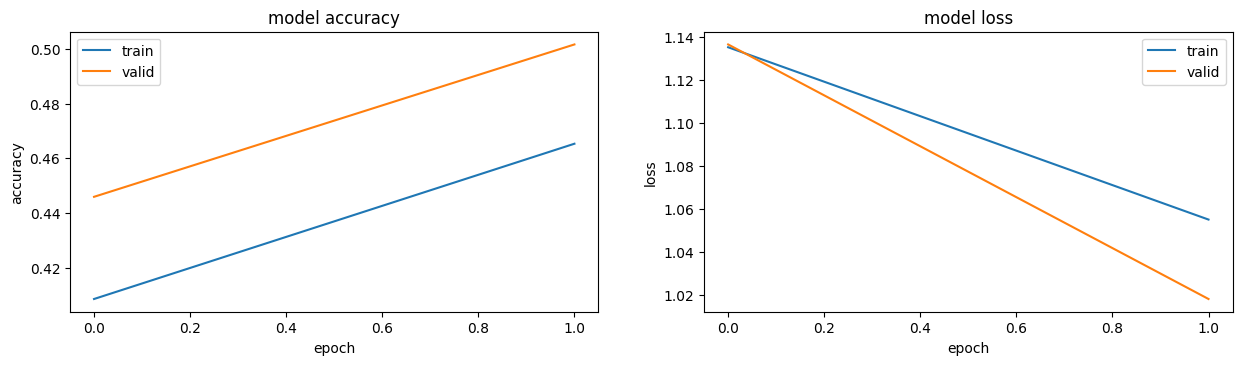

In [110]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

#plt.show()
plt.savefig(os.path.join( results_dir,'learning_curve.png'), bbox_inches='tight')


In [181]:
score = model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print(f'Test loss: {score[0]}')

accuracy: 34.36%
Test loss: 8.213876724243164


In [173]:
# import keras
# model = keras.models.load_model(model_dir)


## Salva Predicoes

In [93]:
#datasets = ['test']
datasets = ['train', 'val', 'test']
class_names = train_generator.class_indices
class_names = list(class_names.keys()) #lista com cada classe 
print('class_names ', class_names)


summary_acc=[]
for dataset in datasets:
    print(f"Calculando metricas para {dataset}")
    scores = model.predict(test_generator, verbose=0)
    ds_gen =  dict_generator.get(dataset)
    labels_ids = ds_gen.classes
    filenames = ds_gen.filenames
    preds_ids = np.argmax(scores, axis = 1)
    labels_name = [class_names[label_index] for label_index in labels_ids]
    preds_name = [class_names[label_index] for label_index in preds_ids]

    predictons_df = pd.DataFrame({'filename':filenames,  'label': labels_name, 'prediction': preds_name})
    predictons_df[class_names] = scores
    
    predictons_df.to_csv(os.path.join(results_dir, dataset+'-predictions.csv'), index=False)
    
    ds_acc = accuracy_score(predictons_df['label'], predictons_df['prediction']) *100 
    print(f"Acuracia {dataset} = ",ds_acc )
    summary_acc.append({'dataset':dataset, 'acc':ds_acc })
    
pd.DataFrame(summary_acc).to_csv(os.path.join(results_dir, 'acc_sumary.csv'), index=False)
    

class_names  ['Acne and Rosacea Photos', 'Nail Fungus and other Nail Disease', 'Psoriasis pictures Lichen Planus and related diseases']
Calculando metricas para test


Calculando metricas para test
Acuracia test =  51.391162029459906
